# Projet SY09 - Bigfoot

A FAIRE
* rajouter des commentaires
* essayer en complément des autres variables
* afficher l'accuracy en fonction du nombre de voisins
* utiliser les mêmes train_set pour les deux versions ?

## Import des bibiliothèques

In [5]:
!pip install fog

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

from datetime import datetime
import re
from collections import Counter, defaultdict

from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier

from fog.tokenizers import WordTokenizer

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
#from utils import plot_clustering, add_decision_boundary, plot_dendrogram, scatterplot_pca

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import MDS
from scipy.spatial.distance import cdist
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from scipy.stats import norm
from scipy import linalg
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator


# Taken from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    default_kwargs = dict(leaf_font_size=10)
    default_kwargs.update(kwargs or {})

    dendrogram(linkage_matrix, **default_kwargs)


def scatterplot_pca(
    columns=None, hue=None, style=None, data=None, pc1=1, pc2=2, **kwargs
):
    """Diagramme de dispersion dans le premier plan principal.

    Permet d'afficher un diagramme de dispersion lorsque les données
    ont plus de deux dimensions. L'argument `columns` spécifie la
    liste des colonnes à utiliser pour la PCA dans le jeu de données
    `data`. Les arguments `style` et `hue` permettent de spécifier la
    forme et la couleur des marqueurs. Les arguments `pc1` et `pc2`
    permettent de sélectionner les composantes principales (par défaut
    la première et deuxième). Retourne l'objet `Axes` ainsi que le
    modèle `PCA` utilisé pour réduire la dimension.

    :param columns: Les colonnes quantitatives de `data` à utiliser
    :param hue: La colonne de coloration
    :param style: La colonne du style
    :param data: Le dataFrame Pandas
    :param pc1: La composante en abscisse
    :param pc2: La composante en ordonnée

    """
     # Select relevant columns (should be numeric)
    data_quant = data if columns is None else data[columns]
    data_quant = data_quant.drop(
        columns=[e for e in [hue, style] if e is not None], errors="ignore"
    )

    # Reduce to two dimensions if needed
    if data_quant.shape[1] == 2:
        data_pca = data_quant
        pca = None
    else:
        n_components = max(pc1, pc2)
        pca = PCA(n_components=n_components)
        data_pca = pca.fit_transform(data_quant)
        data_pca = pd.DataFrame(
            data_pca[:, [pc1 - 1, pc2 - 1]], columns=[f"PC{pc1}", f"PC{pc2}"]
        )

    # Keep name, force categorical data for hue and steal index to
    # avoid unwanted alignment
    if isinstance(hue, pd.Series):
        if not hue.name:
            hue.name = "hue"
        hue_name = hue.name
    elif isinstance(hue, str):
        hue_name = hue
        hue = data[hue]
    elif isinstance(hue, np.ndarray):
        hue = pd.Series(hue, name="class")
        hue_name = "class"

    hue = hue.astype("category")
    hue.index = data_pca.index
    hue.name = hue_name

    if isinstance(style, pd.Series):
        if not style.name:
            style.name = "style"
        style_name = style.name
    elif isinstance(style, str):
        style_name = style
        style = data[style]
    elif isinstance(style, np.ndarray):
        style = pd.Series(style, name="style")
        style_name = "style"

    full_data = data_pca
    if hue is not None:
        full_data = pd.concat((full_data, hue), axis=1)
        kwargs["hue"] = hue_name
    if style is not None:
        full_data = pd.concat((full_data, style), axis=1)
        kwargs["style"] = style_name

    x, y = data_pca.columns
    ax = sns.scatterplot(x=x, y=y, data=full_data, **kwargs)

    return ax, pca

def plot_clustering(data, clus1, clus2=None, ax=None, **kwargs):
    """Affiche les données `data` dans le premier plan principal.

    :param data: Le dataFrame Pandas
    :param clus1: Un premier groupement
    :param clus2: Un deuxième groupement
    :param ax: Les axes sur lesquels dessiner

    """

    if ax is None:
        ax = plt.gca()

    other_kwargs = {e: kwargs.pop(e) for e in ["centers", "covars"] if e in kwargs}

    ax, pca = scatterplot_pca(data=data, hue=clus1, style=clus2, ax=ax, **kwargs)

    if "centers" in other_kwargs and "covars" in other_kwargs:
        # Hack to get colors
        # TODO use legend_out = True
        levels = [str(l) for l in np.unique(clus1)]
        hdls, labels = ax.get_legend_handles_labels()
        colors = [
            artist.get_facecolor().ravel()
            for artist, label in zip(hdls, labels)
            if label in levels
        ]
        colors = colors[: len(levels)]

        if data.shape[1] == 2:
            centers_2D = other_kwargs["centers"]
            covars_2D = other_kwargs["covars"]
        else:
            centers_2D = pca.transform(other_kwargs["centers"])
            covars_2D = [
                pca.components_ @ c @ pca.components_.T for c in other_kwargs["covars"]
            ]

        p = 0.9
        sig = norm.ppf(p ** (1 / 2))

        for covar_2D, center_2D, color in zip(covars_2D, centers_2D, colors):
            v, w = linalg.eigh(covar_2D)
            v = 2.0 * sig * np.sqrt(v)

            u = w[0] / linalg.norm(w[0])
            if u[0] == 0:
                angle = np.pi / 2
            else:
                angle = np.arctan(u[1] / u[0])

            angle = 180.0 * angle / np.pi  # convert to degrees
            ell = mpl.patches.Ellipse(center_2D, v[0], v[1], 180.0 + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.5)
            ax.add_artist(ell)

    return ax, pca

def add_decision_boundary(
    model,
    resolution=100,
    ax=None,
    levels=None,
    label=None,
    color=None,
    region=True,
    model_classes=None,
):
    """Trace une frontière et des régions de décision sur une figure existante.

    :param model: Un modèle scikit-learn ou une fonction `predict`
    :param resolution: La discrétisation en nombre de points par abcisses/ordonnées à utiliser
    :param ax: Les axes sur lesquels dessiner
    :param label: Le nom de la frontière dans la légende
    :param color: La couleur de la frontière
    :param region: Colorer les régions ou pas
    :param model_classes: Les étiquettes des classes dans le cas où `model` est une fonction

    """

    # Set axes
    if ax is None:
        ax = plt.gca()

    # Add decision boundary to legend
    color = "red" if color is None else color
    sns.lineplot(x=[0], y=[0], label=label, ax=ax, color=color, linestyle="dashed")

    # Create grid to evaluate model
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx = np.linspace(xlim[0], xlim[1], resolution)
    yy = np.linspace(ylim[0], ylim[1], resolution)
    XX, YY = np.meshgrid(xx, yy)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    def draw_boundaries(XX, YY, Z_num, color):
        # Boundaries
        mask = np.zeros_like(Z_num, dtype=bool)
        for k in range(len(model_classes) - 1):
            mask |= Z_num == k - 1
            Z_num_mask = np.ma.array(Z_num, mask=mask)
            ax.contour(
                XX,
                YY,
                Z_num_mask,
                levels=[k + 0.5],
                linestyles="dashed",
                corner_mask=True,
                colors=[color],
                antialiased=True,
            )

    def get_regions(predict_fun, xy, shape, model_classes):
        Z_pred = predict_fun(xy).reshape(shape)
        cat2num = {cat: num for num, cat in enumerate(model_classes)}
        num2cat = {num: cat for num, cat in enumerate(model_classes)}
        vcat2num = np.vectorize(lambda x: cat2num[x])
        Z_num = vcat2num(Z_pred)
        return Z_num, num2cat

    def draw_regions(ax, model_classes, num2cat, Z_num):
        # Hack to get colors
        # TODO use legend_out = True
        slabels = [str(l) for l in model_classes]
        hdls, hlabels = ax.get_legend_handles_labels()
        hlabels_hdls = {l: h for l, h in zip(hlabels, hdls)}

        color_dict = {}
        for label in model_classes:
            if str(label) in hlabels_hdls:
                hdl = hlabels_hdls[str(label)]
                color = hdl.get_facecolor().ravel()
                color_dict[label] = color
            else:
                raise Exception("No corresponding label found for ", label)

        colors = [color_dict[num2cat[i]] for i in range(len(model_classes))]
        cmap = mpl.colors.ListedColormap(colors)

        ax.imshow(
            Z_num,
            interpolation="nearest",
            extent=ax.get_xlim() + ax.get_ylim(),
            aspect="auto",
            origin="lower",
            cmap=cmap,
            alpha=0.2,
        )

    if isinstance(model, BaseEstimator):
        if model_classes is None:
            model_classes = model.classes_

        if levels is not None:
            if len(model.classes_) != 2:
                raise Exception("Lignes de niveaux supportées avec seulement deux classes")

            # Scikit-learn model, 2 classes + levels
            Z = model.predict_proba(xy)[:, 0].reshape(XX.shape)
            Z_num, num2cat = get_regions(model.predict, xy, XX.shape, model_classes)

            # Only 2 classes, simple contour
            ax.contour(
                XX,
                YY,
                Z,
                levels=levels,
                colors=[color]
            )

            draw_regions(ax, model_classes, num2cat, Z_num)
        else:
            # Scikit-learn model + no levels
            Z_num, num2cat = get_regions(model.predict, xy, XX.shape, model_classes)

            draw_boundaries(XX, YY, Z_num, color)
            if region:
                draw_regions(ax, model_classes, num2cat, Z_num)
    else:
        if model_classes is None:
            raise Exception("Il faut spécifier le nom des classes")
        if levels is not None:
            raise Exception("Lignes de niveaux avec fonction non supporté")

        # Model is a predict function, no levels
        Z_num, num2cat = get_regions(model, xy, XX.shape, model_classes)
        draw_boundaries(XX, YY, Z_num, color)
        if region:
            draw_regions(ax, model_classes, num2cat, Z_num)

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import MDS
from scipy.spatial.distance import cdist
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from scipy.stats import norm
from scipy import linalg
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator


# Taken from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    default_kwargs = dict(leaf_font_size=10)
    default_kwargs.update(kwargs or {})

    dendrogram(linkage_matrix, **default_kwargs)


def scatterplot_pca(
    columns=None, hue=None, style=None, data=None, pc1=1, pc2=2, **kwargs
):
    """Diagramme de dispersion dans le premier plan principal.

    Permet d'afficher un diagramme de dispersion lorsque les données
    ont plus de deux dimensions. L'argument `columns` spécifie la
    liste des colonnes à utiliser pour la PCA dans le jeu de données
    `data`. Les arguments `style` et `hue` permettent de spécifier la
    forme et la couleur des marqueurs. Les arguments `pc1` et `pc2`
    permettent de sélectionner les composantes principales (par défaut
    la première et deuxième). Retourne l'objet `Axes` ainsi que le
    modèle `PCA` utilisé pour réduire la dimension.

    :param columns: Les colonnes quantitatives de `data` à utiliser
    :param hue: La colonne de coloration
    :param style: La colonne du style
    :param data: Le dataFrame Pandas
    :param pc1: La composante en abscisse
    :param pc2: La composante en ordonnée

    """
     # Select relevant columns (should be numeric)
    data_quant = data if columns is None else data[columns]
    data_quant = data_quant.drop(
        columns=[e for e in [hue, style] if e is not None], errors="ignore"
    )

    # Reduce to two dimensions if needed
    if data_quant.shape[1] == 2:
        data_pca = data_quant
        pca = None
    else:
        n_components = max(pc1, pc2)
        pca = PCA(n_components=n_components)
        data_pca = pca.fit_transform(data_quant)
        data_pca = pd.DataFrame(
            data_pca[:, [pc1 - 1, pc2 - 1]], columns=[f"PC{pc1}", f"PC{pc2}"]
        )

    # Keep name, force categorical data for hue and steal index to
    # avoid unwanted alignment
    if isinstance(hue, pd.Series):
        if not hue.name:
            hue.name = "hue"
        hue_name = hue.name
    elif isinstance(hue, str):
        hue_name = hue
        hue = data[hue]
    elif isinstance(hue, np.ndarray):
        hue = pd.Series(hue, name="class")
        hue_name = "class"

    hue = hue.astype("category")
    hue.index = data_pca.index
    hue.name = hue_name

    if isinstance(style, pd.Series):
        if not style.name:
            style.name = "style"
        style_name = style.name
    elif isinstance(style, str):
        style_name = style
        style = data[style]
    elif isinstance(style, np.ndarray):
        style = pd.Series(style, name="style")
        style_name = "style"

    full_data = data_pca
    if hue is not None:
        full_data = pd.concat((full_data, hue), axis=1)
        kwargs["hue"] = hue_name
    if style is not None:
        full_data = pd.concat((full_data, style), axis=1)
        kwargs["style"] = style_name

    x, y = data_pca.columns
    ax = sns.scatterplot(x=x, y=y, data=full_data, **kwargs)

    return ax, pca

def plot_clustering(data, clus1, clus2=None, ax=None, **kwargs):
    """Affiche les données `data` dans le premier plan principal.

    :param data: Le dataFrame Pandas
    :param clus1: Un premier groupement
    :param clus2: Un deuxième groupement
    :param ax: Les axes sur lesquels dessiner

    """

    if ax is None:
        ax = plt.gca()

    other_kwargs = {e: kwargs.pop(e) for e in ["centers", "covars"] if e in kwargs}

    ax, pca = scatterplot_pca(data=data, hue=clus1, style=clus2, ax=ax, **kwargs)

    if "centers" in other_kwargs and "covars" in other_kwargs:
        # Hack to get colors
        # TODO use legend_out = True
        levels = [str(l) for l in np.unique(clus1)]
        hdls, labels = ax.get_legend_handles_labels()
        colors = [
            artist.get_facecolor().ravel()
            for artist, label in zip(hdls, labels)
            if label in levels
        ]
        colors = colors[: len(levels)]

        if data.shape[1] == 2:
            centers_2D = other_kwargs["centers"]
            covars_2D = other_kwargs["covars"]
        else:
            centers_2D = pca.transform(other_kwargs["centers"])
            covars_2D = [
                pca.components_ @ c @ pca.components_.T for c in other_kwargs["covars"]
            ]

        p = 0.9
        sig = norm.ppf(p ** (1 / 2))

        for covar_2D, center_2D, color in zip(covars_2D, centers_2D, colors):
            v, w = linalg.eigh(covar_2D)
            v = 2.0 * sig * np.sqrt(v)

            u = w[0] / linalg.norm(w[0])
            if u[0] == 0:
                angle = np.pi / 2
            else:
                angle = np.arctan(u[1] / u[0])

            angle = 180.0 * angle / np.pi  # convert to degrees
            ell = mpl.patches.Ellipse(center_2D, v[0], v[1], 180.0 + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.5)
            ax.add_artist(ell)

    return ax, pca

def add_decision_boundary(
    model,
    resolution=100,
    ax=None,
    levels=None,
    label=None,
    color=None,
    region=True,
    model_classes=None,
):
    """Trace une frontière et des régions de décision sur une figure existante.

    :param model: Un modèle scikit-learn ou une fonction `predict`
    :param resolution: La discrétisation en nombre de points par abcisses/ordonnées à utiliser
    :param ax: Les axes sur lesquels dessiner
    :param label: Le nom de la frontière dans la légende
    :param color: La couleur de la frontière
    :param region: Colorer les régions ou pas
    :param model_classes: Les étiquettes des classes dans le cas où `model` est une fonction

    """

    # Set axes
    if ax is None:
        ax = plt.gca()

    # Add decision boundary to legend
    color = "red" if color is None else color
    sns.lineplot(x=[0], y=[0], label=label, ax=ax, color=color, linestyle="dashed")

    # Create grid to evaluate model
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx = np.linspace(xlim[0], xlim[1], resolution)
    yy = np.linspace(ylim[0], ylim[1], resolution)
    XX, YY = np.meshgrid(xx, yy)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    def draw_boundaries(XX, YY, Z_num, color):
        # Boundaries
        mask = np.zeros_like(Z_num, dtype=bool)
        for k in range(len(model_classes) - 1):
            mask |= Z_num == k - 1
            Z_num_mask = np.ma.array(Z_num, mask=mask)
            ax.contour(
                XX,
                YY,
                Z_num_mask,
                levels=[k + 0.5],
                linestyles="dashed",
                corner_mask=True,
                colors=[color],
                antialiased=True,
            )

    def get_regions(predict_fun, xy, shape, model_classes):
        Z_pred = predict_fun(xy).reshape(shape)
        cat2num = {cat: num for num, cat in enumerate(model_classes)}
        num2cat = {num: cat for num, cat in enumerate(model_classes)}
        vcat2num = np.vectorize(lambda x: cat2num[x])
        Z_num = vcat2num(Z_pred)
        return Z_num, num2cat

    def draw_regions(ax, model_classes, num2cat, Z_num):
        # Hack to get colors
        # TODO use legend_out = True
        slabels = [str(l) for l in model_classes]
        hdls, hlabels = ax.get_legend_handles_labels()
        hlabels_hdls = {l: h for l, h in zip(hlabels, hdls)}

        color_dict = {}
        for label in model_classes:
            if str(label) in hlabels_hdls:
                hdl = hlabels_hdls[str(label)]
                color = hdl.get_facecolor().ravel()
                color_dict[label] = color
            else:
                raise Exception("No corresponding label found for ", label)

        colors = [color_dict[num2cat[i]] for i in range(len(model_classes))]
        cmap = mpl.colors.ListedColormap(colors)

        ax.imshow(
            Z_num,
            interpolation="nearest",
            extent=ax.get_xlim() + ax.get_ylim(),
            aspect="auto",
            origin="lower",
            cmap=cmap,
            alpha=0.2,
        )

    if isinstance(model, BaseEstimator):
        if model_classes is None:
            model_classes = model.classes_

        if levels is not None:
            if len(model.classes_) != 2:
                raise Exception("Lignes de niveaux supportées avec seulement deux classes")

            # Scikit-learn model, 2 classes + levels
            Z = model.predict_proba(xy)[:, 0].reshape(XX.shape)
            Z_num, num2cat = get_regions(model.predict, xy, XX.shape, model_classes)

            # Only 2 classes, simple contour
            ax.contour(
                XX,
                YY,
                Z,
                levels=levels,
                colors=[color]
            )

            draw_regions(ax, model_classes, num2cat, Z_num)
        else:
            # Scikit-learn model + no levels
            Z_num, num2cat = get_regions(model.predict, xy, XX.shape, model_classes)

            draw_boundaries(XX, YY, Z_num, color)
            if region:
                draw_regions(ax, model_classes, num2cat, Z_num)
    else:
        if model_classes is None:
            raise Exception("Il faut spécifier le nom des classes")
        if levels is not None:
            raise Exception("Lignes de niveaux avec fonction non supporté")

        # Model is a predict function, no levels
        Z_num, num2cat = get_regions(model, xy, XX.shape, model_classes)
        draw_boundaries(XX, YY, Z_num, color)
        if region:
            draw_regions(ax, model_classes, num2cat, Z_num)

## Préparation du jeu de données

In [8]:
# importer données du fichier csv
bigfoot = pd.read_csv("./bigfoot.csv", sep = ",")

### Features engineering

* https://www.kdnuggets.com/2018/12/feature-engineering-explained.html
* https://www.kdnuggets.com/2018/12/feature-building-techniques-tricks-kaggle.html

Changements par rapport au rapport intermédiaire :
* On retire toutes les classes C
* Comme on a pas de visualisation, on prend directement le numéro du mois pour avoir une variable numérique
* On a plus besoin de la variable date (elle est maintenant redondante avec les variables year, month et day)
* On ajoute les variables r et theta (coordonnées polaires) à partir de la latitude et longitude (dans le cas où les classes seraient en cercles concentriques)
* On encode les variables precip_type et season sur plusieurs variables (one-hot-encoding : chaque nouvelle variable est une valeur possible, et la valeur de cette variable est à 1 si c'est la valeur de la variable originelle, à 0 sinon)
* On supprime les variables precip_type et season

In [9]:
bigfoot = bigfoot[bigfoot.classification != "Class C"]

In [10]:
# ajoute des colonnes jour, mois, année
year = bigfoot['date'].copy()
month = bigfoot['date'].copy()
day = bigfoot['date'].copy()

for i in bigfoot['date'].index:
    d = bigfoot['date'][i]
    if str(d) != "nan":
        d_datetime = datetime.strptime(str(d),'%Y-%m-%d')
        year[i] = d_datetime.year
        month[i] = d_datetime.month
        day[i] = d_datetime.day

bigfoot = bigfoot.assign(year = year)
bigfoot = bigfoot.assign(month = month)
bigfoot = bigfoot.assign(day = day)

# temperature_high : fahrenheit en celsius
# temperature_mid : fahrenheit en celsius
# temperature_low : fahrenheit en celsius
# dew_point : fahrenheit en celsius
# wind_speed : miles par heure en kilomètre par heure
# precip_intensity : inch en cm
# visibility : miles en kilomètre
# latitude / longitude : coordonnées polaires
bigfoot = bigfoot.assign(
    temperature_high = (bigfoot.temperature_high - 32) * 5 / 9,
    temperature_mid = (bigfoot.temperature_mid - 32) * 5 / 9,
    temperature_low = (bigfoot.temperature_low - 32) * 5 / 9,
    dew_point = (bigfoot.dew_point - 32) * 5 / 9,
    wind_speed = bigfoot.wind_speed * 1.609344,
    precip_intensity = bigfoot.precip_intensity * 2.54,
    visibility = bigfoot.visibility * 1.609344,
    r = np.sqrt(bigfoot.longitude ** 2 + bigfoot.latitude ** 2 ),
    theta = 2 * np.arctan( bigfoot.latitude / ( bigfoot.longitude + np.sqrt(bigfoot.longitude ** 2 + bigfoot.latitude ** 2 )))
)

# pour le "titre" garde la partie [titre] du format inital “Report [numéro] : [titre]”
bigfoot = bigfoot.assign(
    title = bigfoot.title.str.replace(r'^Report \d*: ', '')
)

# transformation de precip_type en deux colonnes snow et rain
# transformation de season en quatre colonnes
bigfoot["rain"] = 0.0
bigfoot.loc[bigfoot.precip_type == "rain", "rain"] = 1.0
bigfoot["snow"] = 0.0
bigfoot.loc[bigfoot.precip_type == "snow", "snow"] = 1.0
bigfoot["summer"] = 0.0
bigfoot.loc[bigfoot.season == "Summer", "summer"] = 1.0
bigfoot["spring"] = 0.0
bigfoot.loc[bigfoot.season == "Spring", "spring"] = 1.0
bigfoot["fall"] = 0.0
bigfoot.loc[bigfoot.season == "Fall", "fall"] = 1.0
bigfoot["winter"] = 0.0
bigfoot.loc[bigfoot.season == "Winter", "winter"] = 1.0

bigfoot.drop(columns="geohash", inplace=True)
bigfoot.drop(columns="date", inplace=True)
bigfoot.drop(columns=["precip_type"], inplace=True)

<ipython-input-10-ddc8667f1c5e>:40: FutureWarning: The default value of regex will change from True to False in a future version.
  title = bigfoot.title.str.replace(r'^Report \d*: ', '')


### Typage des variables

Changements par rapport au rapport intermédiaire :
* day, month, year castés à float pour éviter d'avoir les nan spécifiques aux entiers

In [11]:
# dictionnaire des états des Etats-Unis et leur abbrévation
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
}

# variables catégorielles
# Attention! Conséquence, variables catégorielles ont des valeurs <NA> à la place de NaN.
bigfoot.county = pd.Categorical(bigfoot.county)
bigfoot.state = pd.Categorical(bigfoot.state, categories=us_state_to_abbrev.keys())
bigfoot.classification = bigfoot.classification.replace("Class A", "A")
bigfoot.classification = bigfoot.classification.replace("Class B", "B")
bigfoot.classification = pd.Categorical(bigfoot.classification, categories=["A", "B"], ordered=True)

bigfoot.observed = bigfoot.observed.astype('str')
bigfoot.location_details = bigfoot.location_details.astype('str')
bigfoot.title = bigfoot.title.astype('str')
bigfoot.summary = bigfoot.summary.astype('str')
bigfoot.number = bigfoot.number.astype('Int64')
bigfoot.day = bigfoot.day.astype(float)
bigfoot.month = bigfoot.month.astype(float)
bigfoot.year = bigfoot.year.astype(float)

### Observer les corrélations pour supprimer des variables

<Axes: >

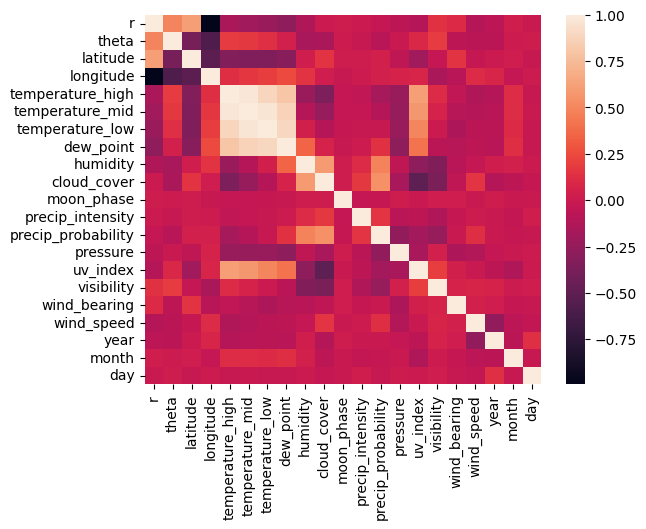

In [12]:
features = [
    'r',
    'theta',
    'latitude',
    'longitude',
    'temperature_high',
    'temperature_mid',
    'temperature_low',
    'dew_point',
    'humidity',
    'cloud_cover',
    'moon_phase',
    'precip_intensity',
    'precip_probability',
    'pressure',
    'uv_index',
    'visibility',
    'wind_bearing',
    'wind_speed',
    'year',
    'month',
    'day'
    ]

corr = bigfoot[features].corr()
sns.heatmap(corr)

<Axes: >

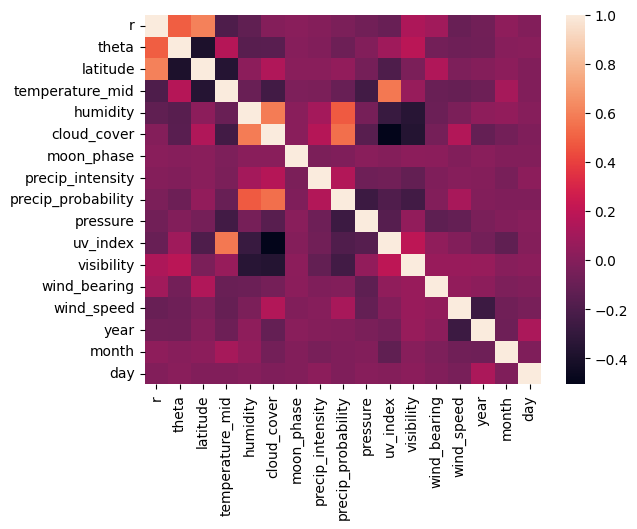

In [13]:
features = [
    'r',
    'theta',
    'latitude',
    'temperature_mid',
    'humidity',
    'cloud_cover',
    'moon_phase',
    'precip_intensity',
    'precip_probability',
    'pressure',
    'uv_index',
    'visibility',
    'wind_bearing',
    'wind_speed',
    'year',
    'month',
    'day'
    ]
corr = bigfoot.drop(columns=["temperature_high", "temperature_low", "dew_point", "longitude"])[features].corr()
sns.heatmap(corr)

In [14]:
bigfoot.drop(columns=["temperature_high", "temperature_low", "dew_point"], inplace=True)

features = [
    'summer',
    'winter',
    'fall',
    'spring',
    'rain',
    'snow',
    'r',
    'theta',
    'latitude',
    'temperature_mid',
    'humidity',
    'cloud_cover',
    'moon_phase',
    'precip_intensity',
    'precip_probability',
    'pressure',
    'uv_index',
    'visibility',
    'wind_bearing',
    'wind_speed',
    'year',
    'month',
    'day'
    ]

cat_cols = [
    'summer',
    'winter',
    'fall',
    'spring',
    'rain',
    'snow',
]

num_cols = [
    'r',
    'theta',
    'latitude',
    'temperature_mid',
    'humidity',
    'cloud_cover',
    'moon_phase',
    'precip_intensity',
    'precip_probability',
    'pressure',
    'uv_index',
    'visibility',
    'wind_bearing',
    'wind_speed',
    'year',
    'month',
    'day'
]

## Traiter le texte

In [15]:
def fill_missing(df):
    '''
    replace empty values by column's mean in dataframe
    '''
    return df.copy().fillna(df.mean())

In [16]:
def calculate_zscore(df):
    '''
    scales columns in dataframe using z-score
    '''
    df = df.copy()
    for col in df.columns:
        if df[col].std(ddof=0) == 0:
            df[col] = (df[col] - df[col].mean())
        else:
            df[col] = (df[col] - df[col].mean()) / df[col].std(ddof=0)

    return df

In [17]:
def normalize_column_modality(df):
    '''
    divides each column by the probability μₘ of the modality
    (number of ones in the column divided by N) only for one hot columns
    '''
    df = df.copy()
    length = len(df)
    for col in df.columns:
        weight = math.sqrt(sum(df[col])/length)
        df[col] = df[col]/weight

    return df

In [18]:
stop_list = ["'m", "while", "near", "'re", "'s", 'report', 'person', 'smh', 'it', 'great', 'there', 'days', 'hate', 'look', 'most', 'phone', 'well', 'watch', "'ve", 'm', 'by', 'cause', 'got', 'out', 'too', 'will', 't', 'get', 'video', 'keep', 'care', 'song', 'd', 'mean', 'was', 'he', 'miss', 'such', 'damn', 'is', 'house', 'a', 'into', 'am', 'been', 'im', 'much', 'one', 'just', 'are', 'really', 'sleep', 'team', 'want', 'work', 'photo', 'gotta', 'its', 'niggas', 'because', 'home', 'already', 'better', 'new', 'now', '3', 'off', 'made', 'over', 'your', 'only', 'tweet', 'week', 'she', 'this', 'didn', 'does', 'god', 'ever', 'dont', 'gonna', "i'", 'after', 'and', 'hard', 'help', 'how', 'in', 'their', 'any', 'him', 'bout', 'never', 'when', 'if', 'take', 'everyone', 'something', 'what', 'talk', "won't", 'they', 's', 'so', 'can', 'show', 'r', 'next', 'tell', 'them', 'guys', 'again', 'than', 'before', 'nigga', 'p', 'thing', 'g', 'w', 'friends', 'best', 'being', 'life', 'said', 'the', 'i', 'l', 'more', 'should', 'play', 'ross', 'someone', 'think', 'on', 'were', 'where', 'far', 'fuck', 'right', 'with', 'school', 'her', 'about', '2012', 'put', 'way', 'fucking', 'twitter', 'back', 'would', 'don', 'or', 'us', 'to', 'e', 'free', 'need', 'thank', 'who', '0', 'hip', 'every', 'gone', 'o', 'bad', 'head', 'at', 'ass', 'ready', 'day', 'll', 'heart', 'his', 'time', "'d", "'ll", 'my', 'f', 'all', 'has', 've', 'other', 'going', 'having', 'shit', 'an', 'go', 'wait', 'did', 'like', 'many', 'follow', 'last', 'morning', 'we', 'away', 'tomorrow', 'you', 'cool', 'no', 'that', 'feel', 'here', 'real', 'had', "don't", 'do', 're', 'live', "can't", 'news', 'lt', 'today', 'love', 'why', 'world', 'check', 'still', 'for', 'know', 'see', 'wish', 'have', 'cant', 'give', 'things', 'two', 'down', 'stop', 'say', 'class', 'done', 'thanks', 'looking', 'up', 'be', 'start', 'find', 'nothing', '1', 'tho', 'though', '2', 'won', 'another', 'hair', 'watching', 'please', 'make', 'then', 'even', 'people', 'let', 'year', 'everything', 'h', 'big', 'girls', 'wanna', 'could', 'from', 'our', 'ain', 'but', 'c', 'doing', 'hop', 'old', 'some', 'of', 'good', 'nice', 'n', 'b', 'as', 'money', 'girl', 'around', 'u', 'face', 'bitch', 'not', 'game', 'always', 'j', 'long', 'lmao', 'same', 'k', 'little', 'getting', 'win', 'these', 'hope', 'amp', 'tonight', 'man', 'come']
NUMBER_PARENTHESIS = re.compile(r"[0-9\(\)]")

tokenizer = WordTokenizer(lower=True, unidecode=True, drop=["punct", "number"], stoplist=stop_list)

IDF -> si le terme est important pour le document. Plus c'est grand, plus le terme est spécifique au document.

TF -> à quel point le terme est présent au sein du document.

Pour les variables python finissant en class, on considère qu'un document correspond à l'ensemble des textes de la classe

In [19]:
bigfoot.shape[0]

4991

In [20]:
tokens_series = bigfoot.title.copy()
tokens = Counter()
tokens_per_report = defaultdict(Counter)
tokens_per_class = defaultdict(Counter)
report_per_token = defaultdict(set)
class_per_token = defaultdict(set)
TF = defaultdict(Counter)

for i in bigfoot[:].index:
    if bigfoot["title"][i] == "nan":
        continue
    tokens_series[i] = "|".join([i for _, i in tokenizer.tokenize(bigfoot["title"][i])])
    for _, token in tokenizer.tokenize(bigfoot["title"][i]):
        if not NUMBER_PARENTHESIS.search(token):
            tokens[token] += 1
            tokens_per_report[bigfoot["number"][i]][token] += 1
            tokens_per_class[bigfoot["classification"][i]][token] += 1
            report_per_token[token].add(bigfoot["number"][i])
            class_per_token[token].add(bigfoot["classification"][i])
    for _, token in tokenizer.tokenize(bigfoot["title"][i]):
        if sum(i for _, i in tokens_per_report[bigfoot["number"][i]].most_common()) != 0:
            TF[bigfoot["number"][i]][token] = tokens_per_report[bigfoot["number"][i]][token] / sum(i for _, i in tokens_per_report[bigfoot["number"][i]].most_common())

bigfoot = bigfoot.assign(tokens = tokens_series)

In [21]:
tokens_per_class["A"].most_common(10)

[('sighting', 904),
 ('encounter', 256),
 ('daylight', 254),
 ('creature', 240),
 ('road', 230),
 ('night', 186),
 ('motorist', 178),
 ('large', 157),
 ('river', 148),
 ('nighttime', 146)]

In [22]:
tokens_per_class["B"].most_common(10)

[('possible', 849),
 ('vocalizations', 325),
 ('sighting', 264),
 ('heard', 233),
 ('lake', 222),
 ('outside', 184),
 ('hear', 182),
 ('night', 179),
 ('hears', 171),
 ('encounter', 165)]

In [23]:
IDF = Counter()
for index_most, token in enumerate(tokens):
    if len(report_per_token[token]) != 0:
        IDF[token] = math.log( bigfoot.shape[0] / len(report_per_token[token]) )

In [24]:
IDF.most_common(10)

[('bicycling', 8.515391569469609),
 ('somers', 8.515391569469609),
 ('peavine', 8.515391569469609),
 ('claremont', 8.515391569469609),
 ('omaha', 8.515391569469609),
 ('minot', 8.515391569469609),
 ('impressions', 8.515391569469609),
 ('lucid', 8.515391569469609),
 ('classic', 8.515391569469609),
 ('saquatches', 8.515391569469609)]

In [25]:
pd.DataFrame(tokens_per_class["A"].most_common(200))

,0,1
0,sighting,904
1,encounter,256
2,daylight,254
3,creature,240
4,road,230
...,...,...
195,squirrel,11
196,hears,11
197,above,11
198,red,11


<Axes: xlabel='0'>

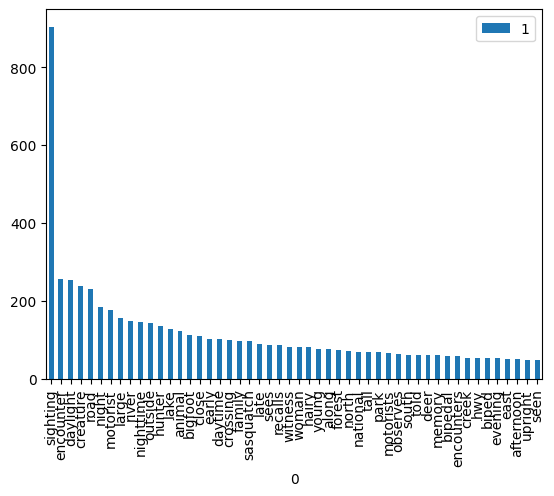

In [26]:
pd.DataFrame(tokens_per_class["A"].most_common(50)).plot.bar(x=0, y=1)

<Axes: xlabel='0'>

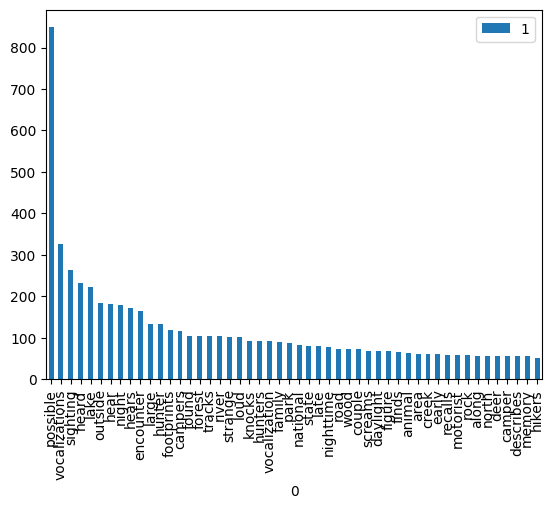

In [27]:
pd.DataFrame(tokens_per_class["B"].most_common(50)).plot.bar(x=0, y=1)

In [28]:
tokens_to_use = set([i for i, _ in tokens_per_class["A"].most_common(10)] + [i for i, _ in tokens_per_class["B"].most_common(10)])

In [29]:
tokens_to_use

{'creature',
 'daylight',
 'encounter',
 'hear',
 'heard',
 'hears',
 'lake',
 'large',
 'motorist',
 'night',
 'nighttime',
 'outside',
 'possible',
 'river',
 'road',
 'sighting',
 'vocalizations'}

In [30]:
# TF-IDF
TF_IDF = defaultdict(Counter)
for index_bigfoot in bigfoot[:].index:
    for index_most, token in enumerate(tokens_to_use):
        TF_IDF[bigfoot["number"][index_bigfoot]][token] = TF[bigfoot["number"][index_bigfoot]][token] * IDF[token]

In [31]:
most_present_columns_0_1 = [bigfoot.title.copy() for i in tokens_to_use]
most_present_columns_TF_IDF = [bigfoot.title.copy() for i in tokens_to_use]

### One-hot-encoding

In [32]:
for index_bigfoot in bigfoot[:].index:
    for index_most, token in enumerate(tokens_to_use):
        if token in tokens_per_report[bigfoot["number"][index_bigfoot]]:
            most_present_columns_0_1[index_most][index_bigfoot] = 1
        else:
            most_present_columns_0_1[index_most][index_bigfoot] = 0

for index_most, token in enumerate(tokens_to_use):
    bigfoot[token] = most_present_columns_0_1[index_most]

In [33]:
bigfoot_famd = normalize_column_modality(bigfoot[list(tokens_to_use)])

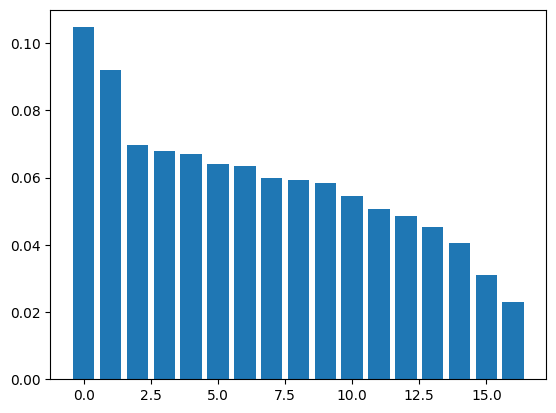

In [34]:
cls = PCA()
pcs = cls.fit_transform(bigfoot_famd)
plt.bar(range(cls.components_.shape[0]), cls.explained_variance_ratio_)
plt.show()

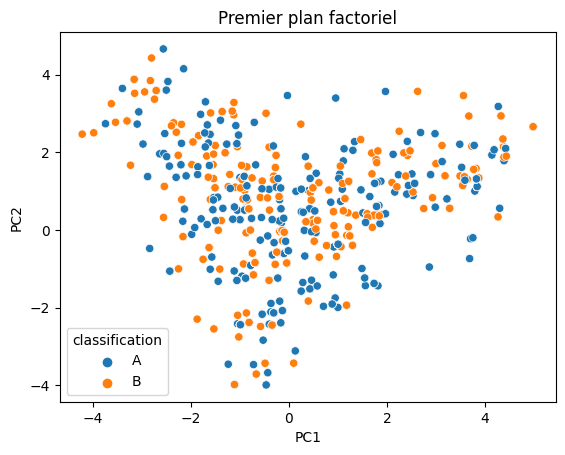

In [35]:
df_X = pd.DataFrame(pcs, columns=[f"PC{i+1}" for i in range(cls.components_.shape[0])])
sns.scatterplot(x="PC1", y="PC2", hue=bigfoot.classification, data=df_X)
plt.title("Premier plan factoriel")
plt.show()

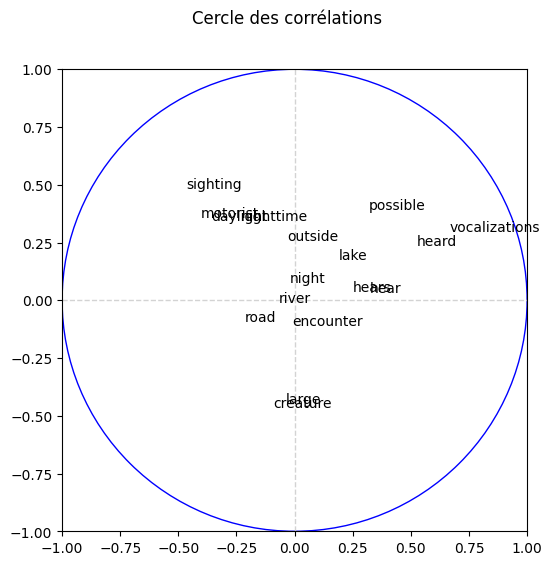

In [36]:
n = bigfoot_famd.shape[0] # nb individus
p = bigfoot_famd.shape[1] # nb variables
eigval = (n-1) / n * cls.explained_variance_ # valeurs propres
sqrt_eigval = np.sqrt(eigval) # racine carrée des valeurs propres
corvar = np.zeros((p,p)) # matrice vide pour avoir les coordonnées
for k in range(p):
    corvar[:,k] = cls.components_[k,:] * sqrt_eigval[k]
# on modifie pour avoir un dataframe
coordvar = pd.DataFrame({'id': list(tokens_to_use), 'COR_1': corvar[:,0], 'COR_2': corvar[:,1]})

# Création d'une figure vide (avec des axes entre -1 et 1 + le titre)
fig, axes = plt.subplots(figsize = (6,6))
fig.suptitle("Cercle des corrélations")
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)
# Ajout des axes
axes.axvline(x = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
axes.axhline(y = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
# Ajout des noms des variables
for j in range(p):
    axes.text(coordvar["COR_1"][j],coordvar["COR_2"][j], coordvar["id"][j])
# Ajout du cercle
plt.gca().add_artist(plt.Circle((0,0),1,color='blue',fill=False))

plt.show()

In [37]:
coordvar

,id,COR_1,COR_2
0,nighttime,-0.233554,0.347277
1,possible,0.318389,0.393508
2,motorist,-0.401688,0.361213
3,encounter,-0.012226,-0.109930
4,night,-0.019281,0.079272
5,large,-0.037185,-0.444688
6,hear,0.324083,0.032578
7,creature,-0.091977,-0.462366
8,lake,0.189332,0.177727
9,road,-0.213212,-0.089780


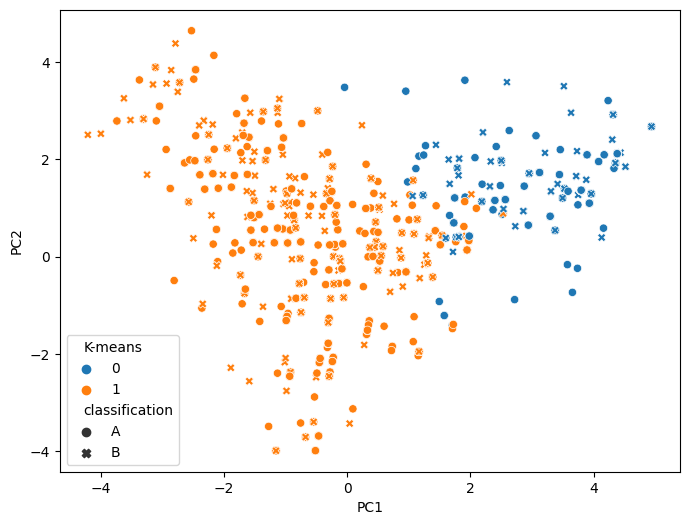

In [38]:
kmeans3 = KMeans(n_clusters=2, n_init=10)
kmeans3.fit(bigfoot_famd)
plt.figure(figsize=(8,6))
labels = pd.Series(kmeans3.labels_, name="K-means")
ax, _ = scatterplot_pca(data=bigfoot_famd, hue=labels, style=bigfoot.classification)
plt.show()
fig = ax.get_figure()

In [39]:
# Séparer le jeu de donnéees
X_train, X_test, y_train, y_test = train_test_split(bigfoot_famd, bigfoot.classification, train_size=0.66)

In [40]:
# validation croisées pour trouver le meilleur nombre de voisins

# De 1 à 500 voisins (exclu), échelle logarithmique
n_neighbors_list = np.unique(np.round(np.geomspace(1, 500, 100)).astype(int))
param_grid = {"n_neighbors": n_neighbors_list}

cls = KNeighborsClassifier()
search = GridSearchCV(cls, param_grid, scoring="accuracy", cv=10)
search.fit(X_train, y_train)
y_pred = search.predict(X_test)
accuracy_score(y_pred, y_test), search.best_params_

(0.7259870359457867, {'n_neighbors': 284})

In [41]:
models = [
    (LinearDiscriminantAnalysis, "ADL"),
    (QuadraticDiscriminantAnalysis, "ADQ"),
    (GaussianNB, "BN"),
    (LogisticRegression, "RL"),
    (DecisionTreeClassifier, "Arbre décision"),
    (RandomForestClassifier, "Forêt aléatoire")
]

def validation_errors(X, y, models):
    for model, name in models:
        for acc in cross_val_score(model(), X, y, cv=20):
            yield name, acc

def add_decision_boundaries(df, models):
    colors = sns.color_palette()
    for model, name in models:
        y = df.classification
        X = df.drop(columns=["classification"])
        cls = model()
        cls.fit(X, y)
        add_decision_boundary(cls, label=name, color=colors.pop(), region=False)

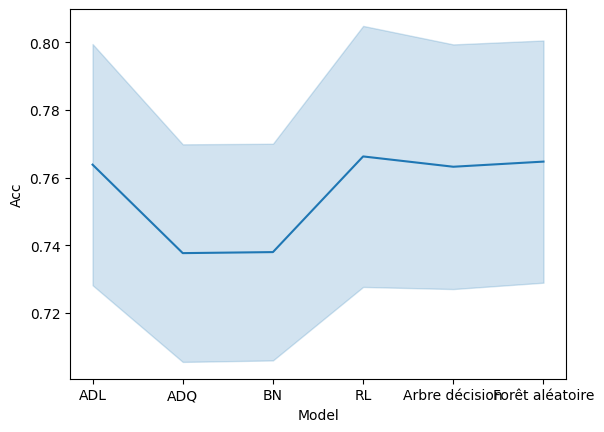

In [42]:
 df = pd.DataFrame(validation_errors(X_train, y_train, models), columns=["Model","Acc"])
sns.lineplot(x="Model", y="Acc", data=df, errorbar="sd")
plt.show()

In [43]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_pred, y_test))

0.7477902180318209


In [44]:
print(clf.classes_)
print(clf.coef_)

['A' 'B']
[[-0.05899729  2.06869904 -0.10127608 -0.32892329  0.06517549 -0.01952407
   0.60988288 -0.39794449  0.13384405 -0.29139631  0.37404303  0.45512726
  -0.01689226 -0.06400898 -1.1759064  -0.23650557  0.36351794]]


In [45]:
X_train.columns

Index(['nighttime', 'possible', 'motorist', 'encounter', 'night', 'large',
       'hear', 'creature', 'lake', 'road', 'vocalizations', 'hears', 'outside',
       'river', 'sighting', 'daylight', 'heard'],
      dtype='object')

In [46]:
RL_coeff = pd.DataFrame({'variable': X_train.columns, 'coeff_RL': clf.coef_[0]})
RL_coeff.sort_values("coeff_RL")

,variable,coeff_RL
14,sighting,-1.175906
7,creature,-0.397944
3,encounter,-0.328923
9,road,-0.291396
15,daylight,-0.236506
2,motorist,-0.101276
13,river,-0.064009
0,nighttime,-0.058997
5,large,-0.019524
12,outside,-0.016892


In [47]:
from collections import defaultdict
import statistics

def list_validation_errors(X, y, models):
  results = []
  for model, name in models:
    for acc in cross_val_score(model(), X, y, cv=20):
      results.append(tuple((name, acc)))
  return results

def calculate_mean_by_first_element(lst):
    # Create a defaultdict to group tuples by their first element
    groups = defaultdict(list)

    # Group tuples by first element
    for item in lst:
        first_element = item[0]
        second_element = item[1]
        groups[first_element].append(second_element)

    # Calculate mean for each group
    result = {}
    for key, values in groups.items():
        result[key] = statistics.mean(values)

    return result

In [48]:
calculate_mean_by_first_element(list_validation_errors(X_train, y_train, models))

{'ADL': 0.7638525498891352,
 'ADQ': 0.7377180339985219,
 'BN': 0.7380210643015521,
 'RL': 0.766280487804878,
 'Arbre décision': 0.7623226164079823,
 'Forêt aléatoire': 0.7650609756097562}

### TF-IDF

In [49]:
for index_bigfoot in bigfoot[:].index:
    for index_most, token in enumerate(tokens_to_use):
        most_present_columns_TF_IDF[index_most][index_bigfoot] = TF_IDF[bigfoot["number"][index_bigfoot]][token]

for index_most, token in enumerate(tokens_to_use):
    bigfoot[token] = most_present_columns_TF_IDF[index_most]

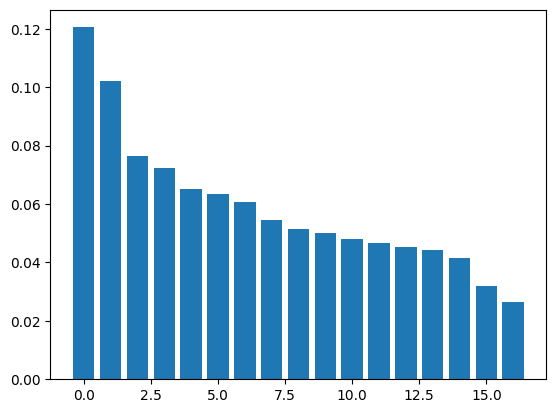

In [50]:
bigfoot_famd = bigfoot[list(tokens_to_use)]
cls = PCA()
pcs = cls.fit_transform(bigfoot_famd)
plt.bar(range(cls.components_.shape[0]), cls.explained_variance_ratio_)
plt.show()

In [51]:
eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(cls.explained_variance_.size)],
        "Variance expliquée" : cls.explained_variance_,
        "% variance expliquée" : np.round(cls.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(cls.explained_variance_ratio_) * 100)
    }
)
eig

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,Dim1,0.021198,12.0,12.0
1,Dim2,0.017948,10.0,22.0
2,Dim3,0.013427,8.0,30.0
3,Dim4,0.012704,7.0,37.0
4,Dim5,0.011432,6.0,44.0
5,Dim6,0.011168,6.0,50.0
6,Dim7,0.010671,6.0,56.0
7,Dim8,0.009574,5.0,61.0
8,Dim9,0.009077,5.0,67.0
9,Dim10,0.008825,5.0,72.0


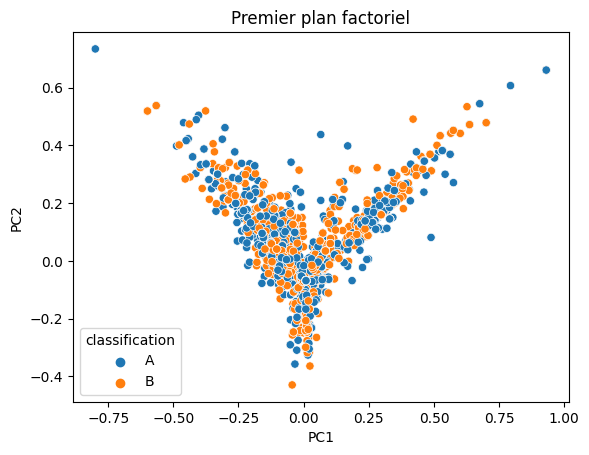

In [52]:
df_X = pd.DataFrame(pcs, columns=[f"PC{i+1}" for i in range(cls.components_.shape[0])])
sns.scatterplot(x="PC1", y="PC2", hue=bigfoot.classification, data=df_X)
plt.title("Premier plan factoriel")
plt.show()

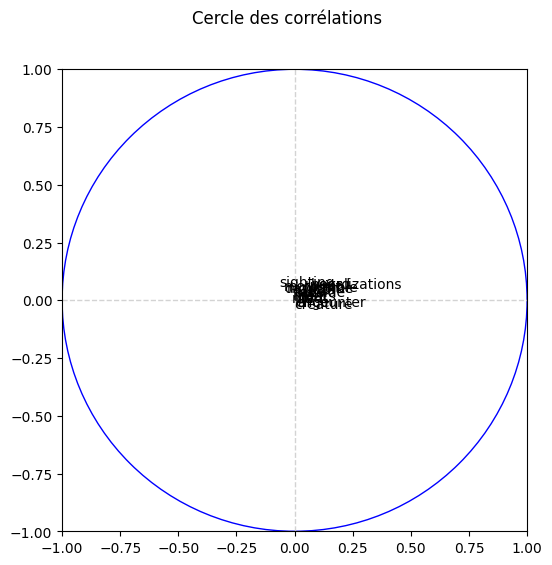

In [53]:
n = bigfoot_famd.shape[0] # nb individus
p = bigfoot_famd.shape[1] # nb variables
eigval = (n-1) / n * cls.explained_variance_ # valeurs propres
sqrt_eigval = np.sqrt(eigval) # racine carrée des valeurs propres
corvar = np.zeros((p,p)) # matrice vide pour avoir les coordonnées
for k in range(p):
    corvar[:,k] = cls.components_[k,:] * sqrt_eigval[k]
# on modifie pour avoir un dataframe
coordvar = pd.DataFrame({'id': list(tokens_to_use), 'COR_1': corvar[:,0], 'COR_2': corvar[:,1]})

# Création d'une figure vide (avec des axes entre -1 et 1 + le titre)
fig, axes = plt.subplots(figsize = (6,6))
fig.suptitle("Cercle des corrélations")
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)
# Ajout des axes
axes.axvline(x = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
axes.axhline(y = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
# Ajout des noms des variables
for j in range(p):
    axes.text(coordvar["COR_1"][j],coordvar["COR_2"][j], coordvar["id"][j])
# Ajout du cercle
plt.gca().add_artist(plt.Circle((0,0),1,color='blue',fill=False))

plt.show()

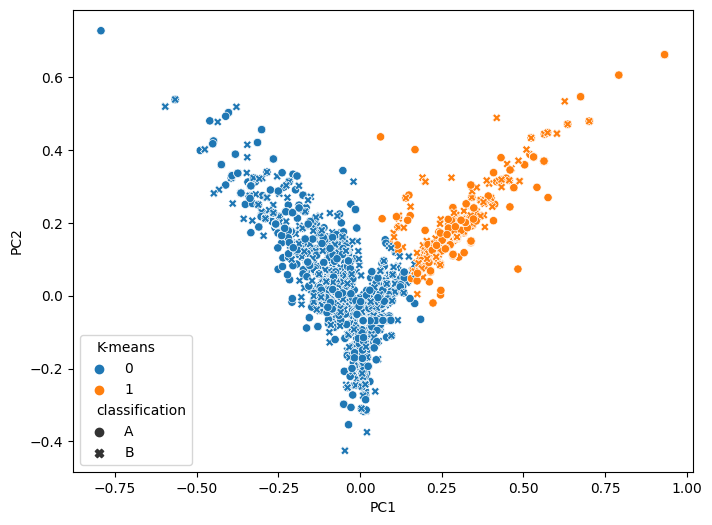

In [54]:
kmeans3 = KMeans(n_clusters=2, n_init=10)
kmeans3.fit(bigfoot_famd)
plt.figure(figsize=(8,6))
labels = pd.Series(kmeans3.labels_, name="K-means")
ax, _ = scatterplot_pca(data=bigfoot_famd, hue=labels, style=bigfoot.classification)
plt.show()
fig = ax.get_figure()

In [55]:
# Séparer le jeu de donnéees
X_train, X_test, y_train, y_test = train_test_split(bigfoot_famd, bigfoot.classification, train_size=0.66)

In [56]:
# validation croisées pour trouver le meilleur nombre de voisins

# De 1 à 500 voisins (exclu), échelle logarithmique
n_neighbors_list = np.unique(np.round(np.geomspace(1, 500, 100)).astype(int))
param_grid = {"n_neighbors": n_neighbors_list}

cls = KNeighborsClassifier()
search = GridSearchCV(cls, param_grid, scoring="accuracy", cv=10)
search.fit(X_train, y_train)
y_pred = search.predict(X_test)
accuracy_score(y_pred, y_test), search.best_params_

(0.7418974661166765, {'n_neighbors': 267})

In [61]:
models = [
    (LinearDiscriminantAnalysis, "ADL"),
    (QuadraticDiscriminantAnalysis, "ADQ"),
    (GaussianNB, "BN"),
    (LogisticRegression, "RL"),
    (DecisionTreeClassifier, "Arbre"),
    (RandomForestClassifier, "Forêt aléatoire")
]

def validation_errors(X, y, models):
    for model, name in models:
        for acc in cross_val_score(model(), X, y, cv=10):
            yield name, acc

def add_decision_boundaries(df, models):
    colors = sns.color_palette()
    for model, name in models:
        y = df.classification
        X = df.drop(columns=["classification"])
        cls = model()
        cls.fit(X, y)
        add_decision_boundary(cls, label=name, color=colors.pop(), region=False)

<ipython-input-64-0df06555222f>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.lineplot(x="Model", y="Acc", data=df, ci="sd")


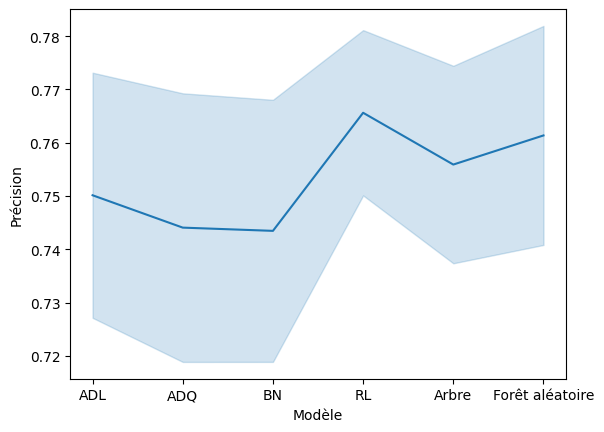

In [64]:
df = pd.DataFrame(validation_errors(X_train, y_train, models), columns=["Model","Acc"])
ax = sns.lineplot(x="Model", y="Acc", data=df, ci="sd")
ax.set(xlabel='Modèle', ylabel='Précision')
plt.show()

In [59]:
model = DecisionTreeClassifier()
clf = BaggingClassifier(model, n_estimators=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_pred, y_test))

0.7218621096051856


In [60]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_pred, y_test))

0.7336476134354744
